### HOG Features with Neural Network Model

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import pandas as pd
import numpy as np

import tez
from tez.datasets import ImageDataset
from tez.callbacks import EarlyStopping

import torch
import torch.nn as nn

import torchvision

from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm

import csv


%matplotlib inline

from skimage.io import imread, imshow
from skimage.feature import hog
from skimage import exposure

#### Example HOG feature visualization

/var/folders/6n/b5wrwg3x67q26b98w8jqq14r0000gn/T/ipykernel_92651/4202566655.py:15: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hogfv, hog_image = hog(image, orientations=9, pixels_per_cell = (16,16),


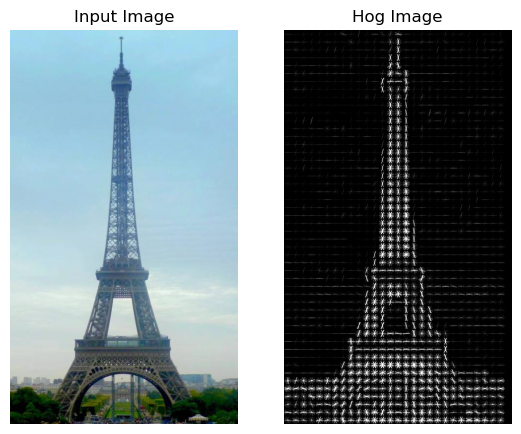

In [6]:
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 3

image = Image.open('TargetImages-TF/1a8029633c722958.jpg')

aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.CenterCrop(size=(400, 400)),
        torchvision.transforms.Resize(size=(400, 400))
    ]
)

augmented_image = aug(image)
hogfv, hog_image = hog(image, orientations=9, pixels_per_cell = (16,16),
                       cells_per_block=(2,2), visualize=True, multichannel=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0,5))
#imshow(hog_image_rescaled)


# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(image)
plt.axis('off')
plt.title("Input Image")

fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(hog_image_rescaled, cmap='gray')
plt.axis('off')
plt.title("Hog Image")
plt.savefig('HOGFeature.png')

## Config

In [2]:
# define global variables
VERSION = 'vHog'
MODEL_PATH = './Model/model' + VERSION + '.bin'
TEST_PREDICTION_FILE = './TargetData-Test-Prediction-' + VERSION + '.csv'
CLASS_ACCURACY_FILE = './TargetData-Test-Accuracy-' + VERSION + '.csv'

IMAGE_SIZE = (400, 400)
TRAIN_BATCH_SIZE  = 128
VALID_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 6e-5

TRAINING_DATA_PATH = './TargetData-Train.csv'
VALIDATION_DATA_PATH = './TargetData-Valid.csv'
TEST_DATA_PATH = './TargetData-Test.csv'

IMAGE_FOLDER_PATH = './TargetImages/'


device = torch.device("cpu")
torch.cuda.empty_cache()
print(f'Device: {device}')

Device: cpu


## Dataset

For each dataset (train, validation and test), load data, augment image (crop image), and compute HOG features.

In [7]:
class GLRDataset:
    def __init__(self, image_paths, targets, augmentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)    
    
    # compute/extract hog features
    def __getitem__(self, item):
        targets = self.targets[item]
        image = Image.open(self.image_paths[item])
        augmented_image = self.augmentations(image)        
        hogfv, hog_image = hog(augmented_image, orientations=9, pixels_per_cell = (16,16),
                       cells_per_block=(2,2), visualize=True, multichannel=True)        
        
        image_tensor = torch.tensor(hogfv.astype(np.float32))
        
        return {
            'image': image_tensor,
            'targets': torch.tensor(targets),
        }

In [4]:
# Training Data
df_train = pd.read_csv(TRAINING_DATA_PATH)
train_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_train.id.values
]
train_targets = df_train.label.values
train_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
train_dataset = GLRDataset(
    image_paths = train_image_paths,
    targets = train_targets,
    augmentations = train_aug
)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)
print(f'Total Batches in Train: {len(train_data_loader)}')
###############################################################

# Validation Data
df_valid = pd.read_csv(VALIDATION_DATA_PATH)
valid_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_valid.id.values
]
valid_targets = df_valid.label.values
valid_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.CenterCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1])),
        torchvision.transforms.Resize(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
valid_dataset = GLRDataset(
    image_paths = valid_image_paths,
    targets = valid_targets,
    augmentations = valid_aug
)
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False
)

print(f'Total Batches in Validation: {len(valid_data_loader)}')
###############################################################


# Test Data
df_test = pd.read_csv(TEST_DATA_PATH)
test_image_paths = [
    os.path.join(IMAGE_FOLDER_PATH, x + '.jpg') for x in df_test.id.values
]
test_targets = df_test.label.values
test_aug = torchvision.transforms.Compose(
    [
        torchvision.transforms.CenterCrop(size=(IMAGE_SIZE[0], IMAGE_SIZE[1])),
        torchvision.transforms.Resize(size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    ]
)
test_dataset = GLRDataset(
    image_paths = test_image_paths,
    targets = test_targets,
    augmentations = test_aug
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

print(f'Total Batches in Test: {len(test_data_loader)}')
###############################################################

Total Batches in Train: 289
Total Batches in Validation: 33
Total Batches in Test: 36


## Model

Use Torch nn linear to apply linear transformation to HOG features

In [5]:
class GLRModel(tez.Model):
    def __init__(self, num_classes):
        super().__init__()
        self.hidden = nn.Linear(20736, 128)
        self.out = nn.Linear(128, num_classes) 
    
    def forward(self, image):
        hidden = self.hidden(image)
        outputs = self.out(hidden)
        
        return outputs

## Loss Function

In [6]:
def loss_function(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)
    
def count_correct(outputs, targets):
    outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    total_correct = np.sum(outputs == targets)
    
    return total_correct

In [ ]:
NUM_CLASSES = df_train.label.nunique()
model = GLRModel(num_classes = NUM_CLASSES)
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.005,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_data_loader) * EPOCHS)
optimizer = torch.optim.AdamW(optimizer_parameters, lr=LEARNING_RATE)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=num_train_steps
)

best_loss = float('inf')
print(f'Model Training Started')

for epoch in range(EPOCHS):
        
    total_train_loss = 0.0
    total_train_correct = 0
    for batch_index, data in tqdm(enumerate(train_data_loader), total=len(train_data_loader)):        
        
        image = data['image']
        targets = data['targets']
        
        image = image.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(image=image)        
        
        loss = loss_function(outputs, targets)
        
        with torch.no_grad():
            total_train_loss += loss.item()
            total_train_correct += count_correct(outputs, targets)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    total_valid_loss = 0.0
    total_valid_correct = 0
    with torch.no_grad():
        model.eval()
        for batch_index, data in tqdm(enumerate(valid_data_loader), total=len(valid_data_loader)):
            image = data['image']
            targets = data['targets']
        
            image = image.to(device)
            targets = targets.to(device)
        
            outputs = model(image=image)
            
            validloss = loss_function(outputs, targets)
            total_valid_loss += validloss.item()            
            total_valid_correct += count_correct(outputs, targets)
            
        total_valid_loss = total_valid_loss / len(valid_data_loader)
        total_train_loss = total_train_loss / len(train_data_loader)
        print(f'Epoch: {epoch + 1} :: Training Loss: {total_train_loss:.4f}, Validation Loss: {total_valid_loss:.4f}')
        print(f'Training Accuracy: {total_train_correct / len(train_dataset) * 100:.2f}, Validation Accuracy: {total_valid_correct / len(valid_dataset) * 100:.2f}')
        
        if total_valid_loss < best_loss:
            torch.save(model.state_dict(), MODEL_PATH)
            best_loss = total_valid_loss

Model Training Started


  0%|                                                                                                                                                                                 | 0/289 [00:00<?, ?it/s]C:\Users\vibhatna.FAREAST\AppData\Local\Temp\ipykernel_20448\710014527.py:14: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hogfv, hog_image = hog(augmented_image, orientations=9, pixels_per_cell = (16,16),
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [07:14<00:00, 13.16s/it]


Epoch: 1 :: Training Loss: 3.6670, Validation Loss: 3.5321
Training Accuracy: 13.62, Validation Accuracy: 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [07:09<00:00, 13.03s/it]


Epoch: 2 :: Training Loss: 3.3611, Validation Loss: 3.3150
Training Accuracy: 17.57, Validation Accuracy: 17.23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [07:09<00:00, 13.02s/it]


Epoch: 3 :: Training Loss: 3.1732, Validation Loss: 3.2020
Training Accuracy: 20.93, Validation Accuracy: 19.01


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 10/33 [02:20<05:24, 14.10s/it]

In [ ]:
NUM_CLASSES = df_train.label.nunique()
loaded_model = GLRModel(num_classes = NUM_CLASSES)
loaded_model.to(device)
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()

total_test_correct = 0
index = 0
df_test['prediction'] = 'Missing Prediction'
with torch.no_grad():
        for batch_index, data in tqdm(enumerate(test_data_loader), total=len(test_data_loader)):
            image = data['image']
            targets = data['targets']
        
            image = image.to(device)
            targets = targets.to(device)
        
            outputs = loaded_model(image=image)
            total_test_correct += count_correct(outputs, targets)
            outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            for i in range(len(targets)):                            
                df_test['prediction'][index] = outputs[i]
                index += 1             

                
print(f'Test Accuracy: {total_test_correct / len(test_dataset) * 100:.2f}')       
df_test.to_csv(TEST_PREDICTION_FILE, sep=',')

#### Load and calculate balanced accuracy results 

In [ ]:
df_prediction = pd.read_csv(TEST_PREDICTION_FILE)
class_correct_count = {}
class_total_count = {}
index = 0
for label in df_prediction.label.values:
    if label not in class_total_count:
        class_total_count[label] = 0
        class_correct_count[label] = 0
        
    if label == df_prediction.prediction[index]:
        class_correct_count[label] += 1
    
    class_total_count[label] += 1
    index+=1


In [ ]:
accuracy_sum = 0.0

with open(CLASS_ACCURACY_FILE, "w", newline='') as filec:
    writerc = csv.writer(filec, delimiter=',')
    writerc.writerow(('class_id','total_count', 'total_correct', 'accuracy'))
    
    for class_id, total_count in class_total_count.items():
        total_correct = class_correct_count[class_id]
        accuracy = total_correct / total_count * 100.0
        accuracy_sum += accuracy
        writerc.writerow((class_id, total_count, total_correct, round(accuracy, 2)))
        
        
print(f'Balanced Accuracy: {accuracy_sum / NUM_CLASSES :.2f}')